# COURSE: A deep understanding of deep learning
## SECTION: Understand and design CNNs
### LECTURE: Classify Gaussian blurs
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [32]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Create Gaussian blurs with different widths

In [33]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

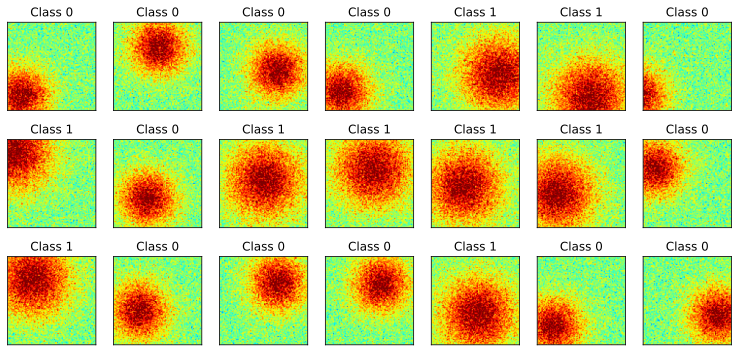

In [34]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create train/test groups using DataLoader

In [35]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [36]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


# Create the DL model

In [37]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
#device = 'cpu'

cuda:0


In [38]:
# create a class for the model
def makeTheNet(fcWidth):

  class gausnet(nn.Module):
    def __init__(self, fcWidth):
      super().__init__()
      
      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # note that relu is treated like a "layer"
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45 
          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22
          nn.Flatten(),                # vectorize conv output
          nn.Linear(22*22*4,2*fcWidth),     # fc1 
          nn.ReLU(),
          nn.Linear(2*fcWidth, fcWidth),    # fc2
          nn.Linear(fcWidth,1),         # output size: 1
      )

      
    def forward(self,x):
      return self.enc(x)
  
  # create the model instance
  net = gausnet(fcWidth)
  
  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [39]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(100)

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print(' ')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
torch.Size([32, 1])
 
Loss:
tensor(0.6914, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [40]:
# count the total number of parameters in the model
#summary(net,(1,imgSize,imgSize))

# Create a function that trains the model

In [41]:
# a function that trains the model

def function2trainTheModel(fcWidth):

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheNet(fcWidth)

  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch

      yHat = yHat.cpu()
      y = y.cpu()

      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    yHat = yHat.cpu()
    y = y.cpu()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

# Run the model and show the results!

In [42]:

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

fcwidths = np.linspace(5, 501, 20).astype(int)

for fcwidth in fcwidths:
    trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel(fcwidth)

    train_loss.append(torch.mean(trainLoss[-5:]))
    test_loss.append(torch.mean(testLoss[-5:]))
    train_accuracy.append(torch.mean(trainAcc[-5:]))
    test_accuracy.append(torch.mean(testAcc[-5:]))

    print(f"Iteration for FC width {fcwidth} completed", end="\r")


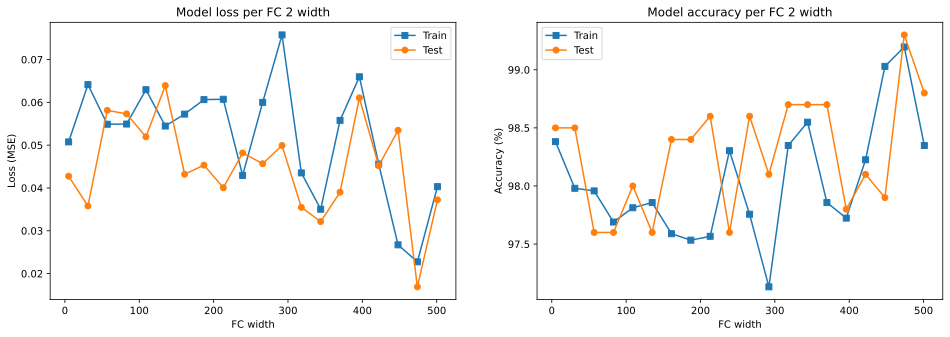

In [43]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(fcwidths,train_loss,'s-',label='Train')
ax[0].plot(fcwidths,test_loss,'o-',label='Test')
ax[0].set_xlabel('FC width')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss per FC 2 width')
ax[0].legend()

ax[1].plot(fcwidths,train_accuracy,'s-',label='Train')
ax[1].plot(fcwidths,test_accuracy,'o-',label='Test')
ax[1].set_xlabel('FC width')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Model accuracy per FC 2 width')
ax[1].legend()

plt.show()

# Additional explorations

In [44]:
# 1) Rewrite the model architecture without using nn.Sequential. Your final result must be the same as the current version,
#    just defined in a different way. This is great practice at constructing models using classes. 
# 
# 2) Find and plot the stimuli that the model guessed incorrectly. Is the correct answer obvious to you? Do the errors
#    tend to be obscured by the boundaries of the image, or is there any other reason you can find for why the model got
#    those wrong?
# 
# 3) Notice the choice of architecture here: 6 channels in the first convolution layer and 4 channels in the second. In
#    the lecture I said that CNNs typically get wider with each successive "convpool block." Does that mean that this
#    model is wrong? Or suboptimal? Think of some arguments for and against this organization. Then modify the code to
#    swap the widths (4 channels in the first conv layer and 6 channels in the second conv layer). Does that affect the
#    model's performance?
# 